In [1]:
import pandas as pd
from tensorflow.keras import layers, models, regularizers
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [2]:
path_csvs = "D:/mestrado/notebooks/dados/features_csv"
cols_to_scale = ['RMSE', 'ZCR', 'COEF_1', 'COEF_2', 'COEF_3', 'COEF_4', 'COEF_5', 'COEF_6', 'COEF_7', 'COEF_8', 'COEF_9', 'COEF_10', 'COEF_11', 'COEF_12', 'COEF_13', 'COEF_14', 'COEF_15', 'COEF_16', 'COEF_17', 'COEF_18', 'COEF_19', 'COEF_20']

In [ ]:
df_feminino_completo_normalizado = pd.read_csv("D:/mestrado/notebooks/dados/features_csv/feminino_completo_normalizado.csv", sep=";")

df_masculino_completo_normalizado = pd.read_csv("D:/mestrado/notebooks/dados/features_csv/masculino_completo_normalizado.csv", sep=";")


In [34]:
import pandas as pd

# Passo 1: Selecionar 1000 áudios distintos aleatoriamente
audios_unicos_femininos = df_feminino_completo_normalizado['Audio'].drop_duplicates().sample(1000, random_state=42)

# Passo 2: Trazer todos os frames desses áudios
subset_df_feminino = df_feminino_completo_normalizado[df_feminino_completo_normalizado['Audio'].isin(audios_unicos_femininos)]

subset_df_feminino['Audio'].nunique()

1000

In [35]:
# Passo 1: Selecionar 1000 áudios distintos aleatoriamente
audios_unicos_masculinos = df_masculino_completo_normalizado['Audio'].drop_duplicates().sample(1000, random_state=42)

# Passo 2: Trazer todos os frames desses áudios
subset_df_masculino = df_masculino_completo_normalizado[df_masculino_completo_normalizado['Audio'].isin(audios_unicos_masculinos)]

subset_df_masculino['Audio'].nunique()

1000

In [36]:
df_mix_completo_normalizado = pd.concat([subset_df_feminino, subset_df_masculino], ignore_index=True)

### Criando Tensor

In [37]:
def dataframe_to_tensor(df, num_features):
    grouped = df.groupby("Audio")
    # Cria uma lista de arrays, um para cada áudio
    tensors = [group.iloc[:, :num_features].values for _, group in grouped]
    return np.array(tensors)  # Converte para um tensor 3D

In [38]:
# Função para padronizar as sequências (com padding ou truncamento)
def standardize_frames(sequences, max_frames):
    standardized_sequences = []
    for seq in sequences:
        if len(seq) < max_frames:
            # Padding: Adiciona zeros ao final da sequência
            padded_seq = np.pad(seq, ((0, max_frames - len(seq)), (0, 0)), mode='constant')
            standardized_sequences.append(padded_seq)
        else:
            # Truncamento: Corta a sequência para o tamanho máximo
            truncated_seq = seq[:max_frames, :]
            standardized_sequences.append(truncated_seq)
    return np.array(standardized_sequences)

In [39]:
grouped = df_mix_completo_normalizado.groupby("Audio")
df_frames = pd.DataFrame()
df_frames['frames'] = df_mix_completo_normalizado.groupby("Audio").size()

In [40]:
df_frames.head()
print(df_frames['frames'].sum())
numero_max_frames = int(df_frames['frames'].mean())

208482


In [41]:
def extract_y(df):
    num_features = 23  # RMS (1) + ZCR (1) + 20 MFCCs
    grouped = df.groupby("Audio")

    # Converta cada áudio para uma matriz (frames x features)
    sequences = [group.iloc[:, :num_features].values for _, group in grouped]

    # Padronize os frames
    max_frames = numero_max_frames  # Defina o número fixo de frames
    tensor = standardize_frames(sequences, max_frames)

    print("Shape do tensor:", tensor.shape)  # Deve ser (num_audios, max_frames, num_features)

    y = []
    for s in sequences:
        for element in s[0]:
            if isinstance(element, str): 
                if 'saudavel' in element:
                        y.append(0)
                else:
                    y.append(1)
                break

    print(len(y))

    return np.array(y)


In [42]:
def extract_tensor_x(df):
    num_features = 22  # RMS (1) + ZCR (1) + 20 MFCCs
    # Agrupe o DataFrame por áudio
    grouped = df.groupby("Audio")

    # Converta cada áudio para uma matriz (frames x features)
    sequences = [group.iloc[:, :num_features].values for _, group in grouped]

    # Padronize os frames
    max_frames = numero_max_frames  # Defina o número fixo de frames
    tensor = standardize_frames(sequences, max_frames)

    print("Shape do tensor:", tensor.shape)  # Deve ser (num_audios, max_frames, num_features)
    return tensor


### Criando a Rede Neural

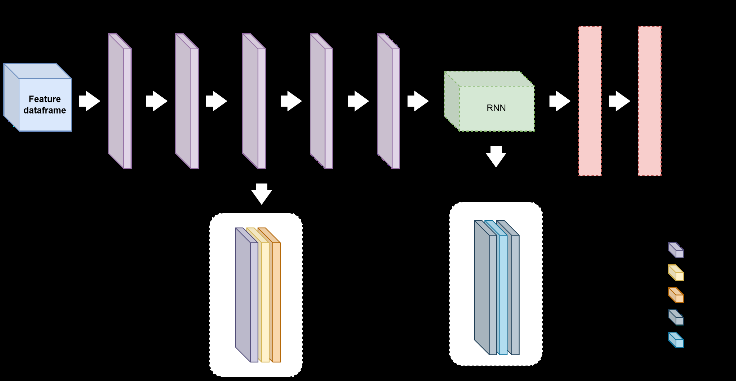

In [43]:
def generate_model():
    # Dimensão das features (exemplo: 20 MFCCs + RMS + ZCR -> 22 features por timestep)
    input_shape = (None, 22)  # None -> Sequência variável, 22 -> Features por timestep

    # Regularização L2 (lambda = 0.01)
    l2_reg = regularizers.L2(0.01)

    # Entrada
    inputs = layers.Input(shape=input_shape)

    # 5 Blocos CNN
    x = inputs
    for _ in range(5):
        x = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=l2_reg)(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.3)(x)  # Dropout adicional

    # LSTM com regularização L2
    x = layers.LSTM(128, return_sequences=True, kernel_regularizer=l2_reg)(x)

    # Camada de Atenção
    attention = layers.Dense(1, activation="tanh", kernel_regularizer=l2_reg)(x)  # Escore de atenção
    attention = layers.Flatten()(attention)  # Remove dimensão extra
    attention = layers.Activation("softmax")(attention)  # Probabilidade
    attention = layers.RepeatVector(128)(attention)  # Ajusta dimensão para aplicar
    attention = layers.Permute([2, 1])(attention)  # Transposição

    x = layers.Multiply()([x, attention])  # Aplicação da atenção
    x = layers.LSTM(128, kernel_regularizer=l2_reg)(x)  # Resumo da sequência com LSTM final

    # Camadas densas para classificação com regularização e Dropout
    x = layers.Dense(64, activation="relu", kernel_regularizer=l2_reg)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid", kernel_regularizer=l2_reg)(x)  # Saída binária

    # Construção do modelo
    model = models.Model(inputs, outputs)

    # Compilação
    # Learning Rate default do Adam = 0.001
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", "binary_accuracy", "precision", "recall"])
    return model

# Resumo do modelo
model_cnn_rnn = generate_model()
model_cnn_rnn.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, None, 22)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, None, 64)  │      4,288 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_70[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_70    │ (None, None, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, None, 64)  │          0 │ max_pooling1d_70… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, None, 64)  │     12,352 │ dropout_84[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_71[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_71    │ (None, None, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, None, 64)  │          0 │ max_pooling1d_71… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, None, 64)  │     12,352 │ dropout_85[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_72[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_72    │ (None, None, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_86          │ (None, None, 64)  │          0 │ max_pooling1d_72… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, None, 64)  │     12,352 │ dropout_86[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 64)  │        256 │ conv1d_73[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_73    │ (None, None, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_87          │ (None, None, 64)  │          0 │ max_pooling1d_73… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, None, 64)  │     12,352 │ dropout_87[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 293,826 (1.12 MB)

 Trainable params: 293,186 (1.12 MB)

 Non-trainable params: 640 (2.50 KB)

In [45]:
# dividindo tensor entre treino, validação e teste
X = extract_tensor_x(df_mix_completo_normalizado)
y = extract_y(df_mix_completo_normalizado)

assert len(y) == 2000
assert X.shape[0] == len(y)

print(len(y))

Shape do tensor: (2000, 104, 22)
Shape do tensor: (2000, 104, 23)
2000
2000


### 10-fold cross-validation

In [ ]:
np.random.seed(42)

# Parâmetros
k = 10  # Número de folds
num_epochs = 20
batch_size = 32
test_size = 0.3  # Porcentagem para o conjunto de teste

np.array([1, 2, 3])
train_accuracies = np.zeros((k, num_epochs))
val_accuracies = np.zeros((k, num_epochs))

# Dividindo os dados em treino+validação e teste
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Configurando o K-Fold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Lista para armazenar as métricas de cada fold
fold_losses = []
fold_accuracies = []
fold_binary_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
histories = []

# k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val)):
    print(f"\nFold {fold+1}/{k}")
    
    # Dividindo os índices para treino e validação
    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
    
    # Criando o modelo
    model = generate_model()
    
    # Early stopping para evitar overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Configuração do ModelCheckpoint
    checkpoint_callback = ModelCheckpoint(
        filepath='/checkpoints/implementacao/feminino_doente_saudavel_melhor_modelo.keras',      # Caminho onde o modelo será salvo
        monitor='val_loss',               # Métrica monitorada (ex: val_loss ou val_accuracy)
        save_best_only=True,              # Salva apenas o melhor modelo
        save_weights_only=False,          # Salva o modelo completo, incluindo arquitetura
        mode='min',                       # Modo de monitoramento (min para loss, max para accuracy)
        verbose=1                         # Exibe mensagens quando o modelo é salvo
    )
    
    # Treinando o modelo
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, checkpoint_callback],
        verbose=1
    )

    # Salvar as acurácias
    train_accuracies[fold] = history.history['accuracy']
    val_accuracies[fold] = history.history['val_accuracy']
    
    # Avaliando no conjunto de validação
    val_loss, val_accuracy, val_binary_accuracy, val_precision, val_recall = model.evaluate(X_val, y_val, verbose=1)
    print(f"Validação - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    fold_accuracies.append(val_accuracy)
    fold_losses.append(val_loss)
    fold_binary_accuracies.append(val_binary_accuracy)
    fold_precisions.append(val_precision)
    fold_recalls.append(val_recall)
    #fold_f1_scores.append(val_f1_score)
    histories.append(history)

# Avaliação final no conjunto de teste
print("\nCross-validation completado.")
print(f"Accuracias por fold: {fold_accuracies}")
print(f"Accuracy média: {np.mean(fold_accuracies):.4f}, Desvio padrão: {np.std(fold_accuracies):.4f}")



Fold 1/10
Epoch 1/20
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5323 - binary_accuracy: 0.5323 - loss: 6.2779 - precision: 0.5300 - recall: 0.6265
Epoch 1: val_loss improved from inf to 2.97646, saving model to /checkpoints/implementacao/feminino_doente_saudavel_melhor_modelo.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.5418 - binary_accuracy: 0.5418 - loss: 6.1567 - precision: 0.5377 - recall: 0.6391 - val_accuracy: 0.4857 - val_binary_accuracy: 0.4857 - val_loss: 2.9765 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8470 - binary_accuracy: 0.8470 - loss: 2.3935 - precision: 0.8537 - recall: 0.8473
Epoch 2: val_loss improved from 2.97646 to 1.83623, saving model to /checkpoints/implementacao/feminino_doente_saudavel_melhor_modelo.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8490 - binary_accuracy: 0.8490 - loss: 2.3479 - precision: 0.8568 - recall: 0.8474 - val_accuracy: 0.

In [56]:
# Avaliando o modelo no conjunto de teste
test_losses = []
test_accuracies = []
test_binary_accuracies = []
test_precisions = []
test_recalls = []
for i in range(10):
    final_model = generate_model()
    history_final = final_model.fit(X_train_val, y_train_val, epochs=num_epochs, batch_size=batch_size, verbose=0)
    test_loss, test_accuracy, test_binary_accuracy, test_precision, test_recall = final_model.evaluate(X_test, y_test, verbose=0)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_binary_accuracies.append(test_binary_accuracy)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)

    print(f"\nDesempenho audios femininos no conjunto de teste - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Binary Accuracy: {test_binary_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")



Desempenho audios femininos no conjunto de teste - Loss: 0.3132, Accuracy: 0.9583, Binary Accuracy: 0.9583, Precision: 0.9572, Recall: 0.9604

Desempenho audios femininos no conjunto de teste - Loss: 0.2989, Accuracy: 0.9700, Binary Accuracy: 0.9700, Precision: 0.9642, Recall: 0.9769

Desempenho audios femininos no conjunto de teste - Loss: 0.2526, Accuracy: 0.9750, Binary Accuracy: 0.9750, Precision: 0.9675, Recall: 0.9835

Desempenho audios femininos no conjunto de teste - Loss: 0.2558, Accuracy: 0.9783, Binary Accuracy: 0.9783, Precision: 0.9770, Recall: 0.9802

Desempenho audios femininos no conjunto de teste - Loss: 0.3098, Accuracy: 0.9617, Binary Accuracy: 0.9617, Precision: 0.9348, Recall: 0.9934

Desempenho audios femininos no conjunto de teste - Loss: 0.3200, Accuracy: 0.9683, Binary Accuracy: 0.9683, Precision: 0.9830, Recall: 0.9538

Desempenho audios femininos no conjunto de teste - Loss: 0.3375, Accuracy: 0.9517, Binary Accuracy: 0.9517, Precision: 0.9692, Recall: 0.9340

In [55]:

print("Media test_losses ", np.mean(test_losses))
print("Media test_accuracies ", np.mean(test_accuracies))
print("Media test_binary_accuracies ", np.mean(test_binary_accuracies))
print("Media test_precisions ", np.mean(test_precisions))
print("Media test_recalls ", np.mean(test_recalls))

Media test_losses  0.28839916586875913
Media test_accuracies  0.9710000097751618
Media test_binary_accuracies  0.9710000097751618
Media test_precisions  0.9796457529067993
Media test_recalls  0.9627062737941742


In [57]:
def f1_score(precisao, recall):
    return 2 * (precisao * recall) / (precisao + recall)


In [58]:
f1_score(0.9572, 0.9604)

0.958797329995828

In [46]:
# Avaliando o modelo no conjunto de teste
final_model = generate_model()
history_final = final_model.fit(X_train_val, y_train_val, epochs=num_epochs, batch_size=batch_size, verbose=1)
test_loss, test_accuracy, test_binary_accuracy, test_precision, test_recall = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nDesempenho audios femininos no conjunto de teste - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Binary Accuracy: {test_binary_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6209 - binary_accuracy: 0.6209 - loss: 5.0016 - precision: 0.6458 - recall: 0.5094
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9261 - binary_accuracy: 0.9261 - loss: 0.8980 - precision: 0.9172 - recall: 0.9394
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9538 - binary_accuracy: 0.9538 - loss: 0.5367 - precision: 0.9490 - recall: 0.9586
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9651 - binary_accuracy: 0.9651 - loss: 0.4022 - precision: 0.9633 - recall: 0.9653
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9735 - binary_accuracy: 0.9735 - loss: 0.3677 - precision: 0.9707 - recall: 0.9754
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9607 - binary_accuracy: 0.9607 - loss: 0.3644 - precision: 0.9542 - recall: 0.9704
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9776 - binary_accuracy: 0.9776 - loss: 0.2901 -